In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from geopy.distance import geodesic

In [13]:
data_train = pd.read_csv('fraudTrain.csv')
data_test = pd.read_csv('fraudTest.csv')
print(data_train.shape)
print(data_test.shape)

(1296675, 23)
(555719, 23)


In [18]:
data = pd.concat([data_train, data_test], ignore_index=True)
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [40]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob'] = pd.to_datetime(data['dob'])
data = data.sort_values(by='trans_date_trans_time')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    datetime64[ns]
 18  trans_num              obje

In [67]:
# Calcul de l'age
data['age'] = (data['trans_date_trans_time'] - data['dob']).dt.days /365.23

## Calcul de Mois
data['mois'] = data['trans_date_trans_time'].dt.month
# Calcul de semaine
data['semaine'] = data['trans_date_trans_time'].dt.isocalendar().week

# Calcul de distance entre marchant et clients
data['distance'] = data.apply(lambda dist: geodesic(([dist["lat"], dist["lat"]]),
    ([ dist["merch_lat"], dist["merch_long"]])).km, axis=1)

In [75]:
data = data.drop(columns=['Unnamed: 0', 'first', 'last', 'street', 'lat', 'long', 'dob','trans_date_trans_time',
                         'merch_lat', 'merch_long', 'trans_num'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1852393
Data columns (total 16 columns):
 #   Column     Dtype  
---  ------     -----  
 0   cc_num     int64  
 1   merchant   object 
 2   category   object 
 3   amt        float64
 4   gender     object 
 5   city       object 
 6   state      object 
 7   zip        int64  
 8   city_pop   int64  
 9   job        object 
 10  unix_time  int64  
 11  is_fraud   int64  
 12  age        float64
 13  mois       int32  
 14  semaine    UInt32 
 15  distance   float64
dtypes: UInt32(1), float64(3), int32(1), int64(5), object(6)
memory usage: 227.9+ MB


# 2. Exploration

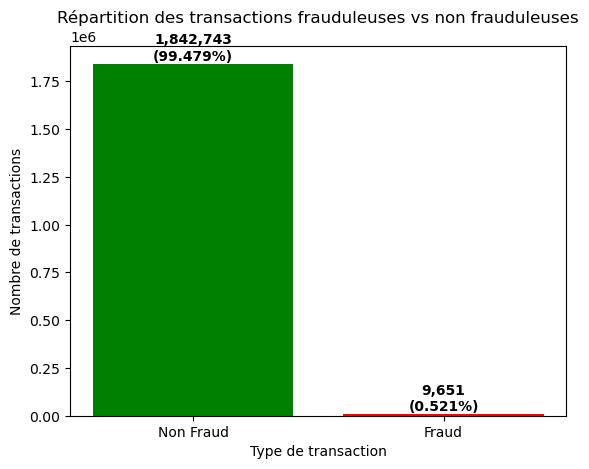

In [93]:
# Comptage des modalités
counts = data['is_fraud'].value_counts().sort_index()
total = counts.sum()

# Noms associés aux labels
labels = [ 'Non Fraud', 'Fraud']

# Couleurs personnalisées
colors = ['green', 'red']

# Création du barplot
plt.bar(labels, counts.values, color=colors)
plt.title("Répartition des transactions frauduleuses vs non frauduleuses")
plt.xlabel("Type de transaction")
plt.ylabel("Nombre de transactions")

# Ajouter les valeurs et pourcentages sur les barres
for i, v in enumerate(counts.values):
    pct = v / total * 100
    plt.text(i, v + 0.01 * max(counts.values),
             f"{v:,}\n({pct:.3f}%)",
             ha='center', fontweight='bold')

plt.show()


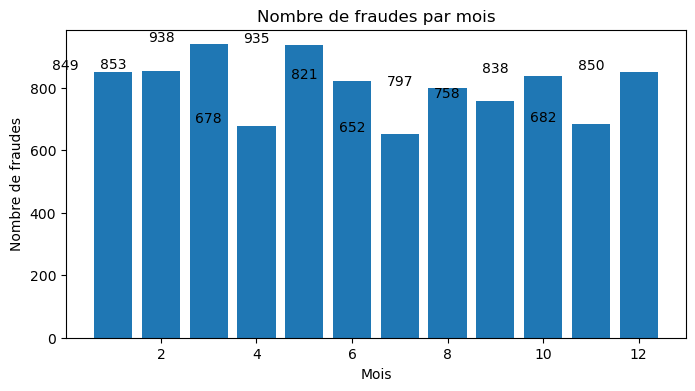

In [133]:
import matplotlib.pyplot as plt

# Filtrer uniquement les fraudes
fraudes = data[data['is_fraud'] == 1]

# Compter le nombre de fraudes par mois
fraudes_par_mois = fraudes['mois'].value_counts().sort_index()

# Tracer le barplot
plt.figure(figsize=(8,4))
plt.bar(fraudes_par_mois.index, fraudes_par_mois.values)
plt.title("Nombre de fraudes par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de fraudes")

# Ajouter les valeurs sur les barres
for i, v in enumerate(fraudes_par_mois.values):
    plt.text(i, v + 0.01 * max(fraudes_par_mois.values),
             f"{v:,}", ha='center', fontweight='bold')

plt.show()


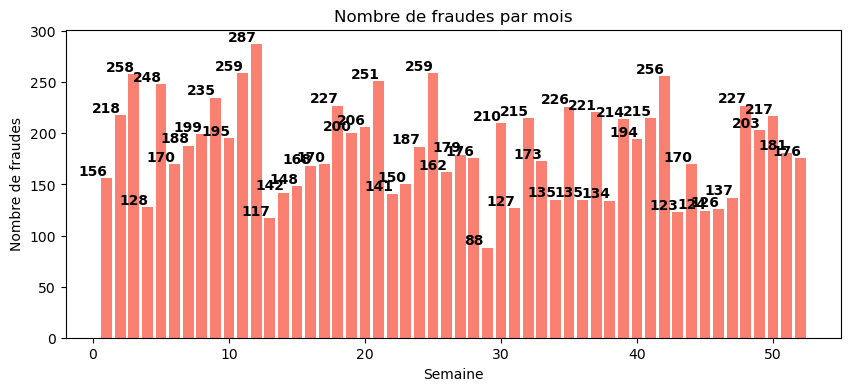

In [145]:
# Filtrer uniquement les fraudes
fraudes = data[data['is_fraud'] == 1]

# Compter le nombre de fraudes par mois
fraudes_par_semaine = fraudes['semaine'].value_counts().sort_index()

# Tracer le barplot
plt.figure(figsize=(10,4))
plt.bar(fraudes_par_semaine.index, fraudes_par_mois.values, color='salmon')
plt.title("Nombre de fraudes par mois")
plt.xlabel("Semaine")
plt.ylabel("Nombre de fraudes")

# Ajouter les valeurs sur les barres
for i, v in enumerate(fraudes_par_mois.values):
    plt.text(i, v + 0.01 * max(fraudes_par_mois.values),
             f"{v:,}", ha='center', fontweight='bold')

plt.show()


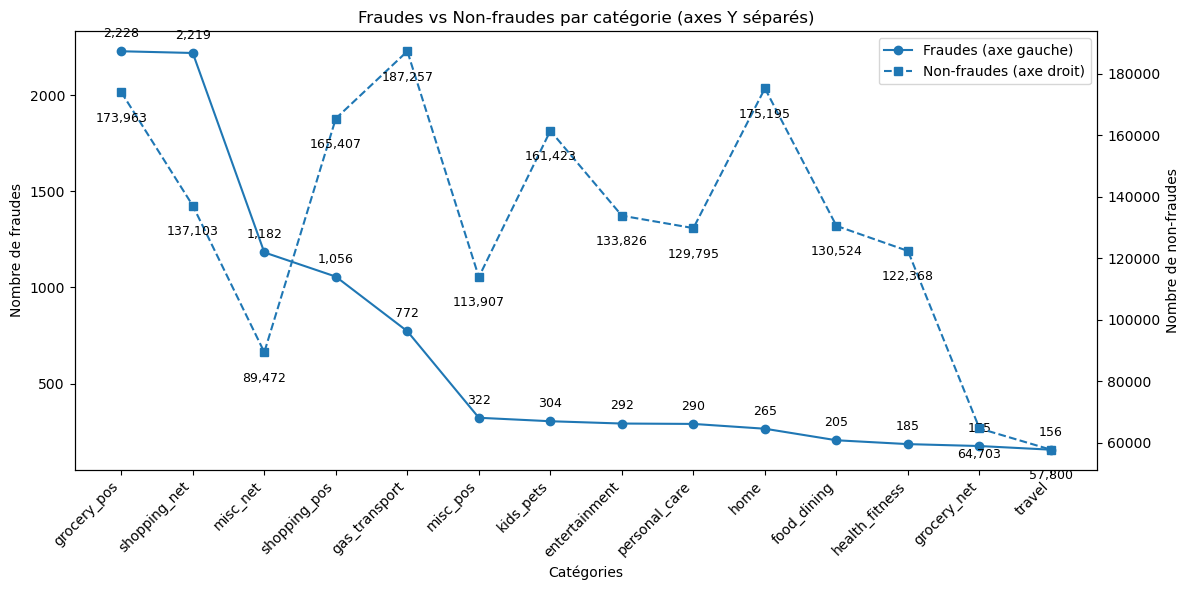

In [151]:
# Table de comptage par catégorie et label (0=non fraude, 1=fraude)
counts = (
    data.groupby(['category', 'is_fraud'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=[0, 1], fill_value=0)  # 0: non-fraude, 1: fraude
)

# Option : trier par nombre de fraudes (desc)
counts = counts.sort_values(by=1, ascending=False)

cats = counts.index.tolist()
x = range(len(cats))
non_fraud = counts[0].values
fraud = counts[1].values

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Courbe Fraude (axe gauche)
l1, = ax1.plot(x, fraud, marker='o', linestyle='-', label='Fraudes (axe gauche)')
ax1.set_ylabel('Nombre de fraudes')

# Courbe Non-fraude (axe droit)
l2, = ax2.plot(x, non_fraud, marker='s', linestyle='--', label='Non-fraudes (axe droit)')
ax2.set_ylabel('Nombre de non-fraudes')

# Axes & titres
ax1.set_title('Fraudes vs Non-fraudes par catégorie (axes Y séparés)')
ax1.set_xlabel('Catégories')
ax1.set_xticks(x)
ax1.set_xticklabels(cats, rotation=45, ha='right')

# Annotations des points (valeurs au-dessus)
for i, v in enumerate(fraud):
    ax1.annotate(f'{v:,}', xy=(i, v), xytext=(0, 8),
                 textcoords='offset points', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(non_fraud):
    # petit décalage pour éviter le chevauchement visuel
    ax2.annotate(f'{v:,}', xy=(i, v), xytext=(0, -14),
                 textcoords='offset points', ha='center', va='top', fontsize=9)

# Légende combinée
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


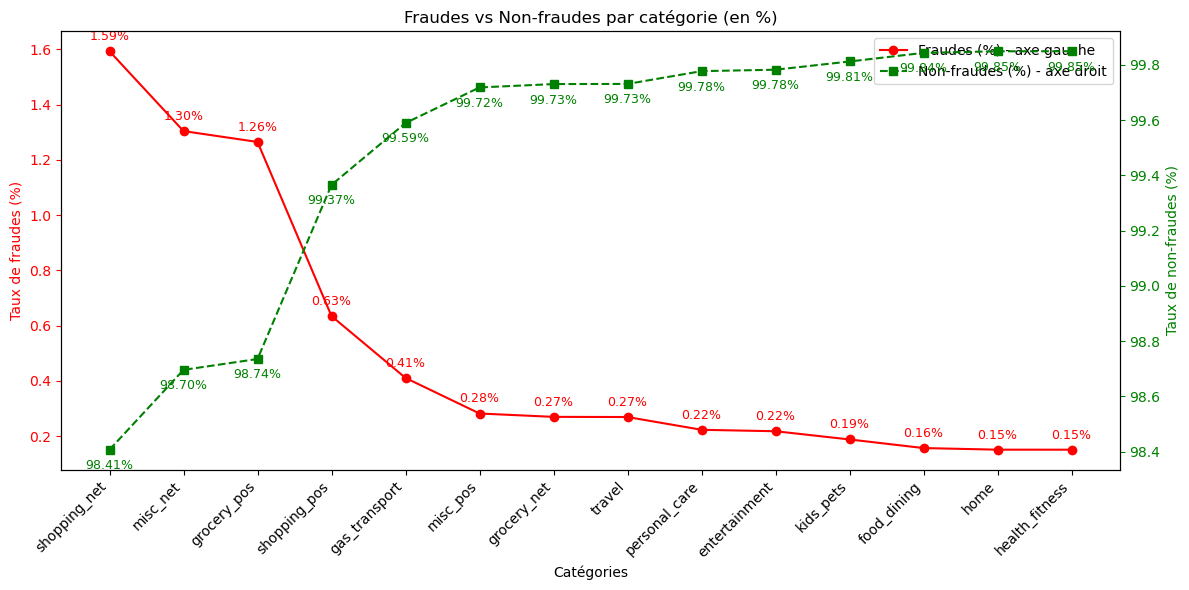

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculer le nombre de fraudes et non-fraudes par catégorie
counts = (
    data.groupby(['category', 'is_fraud'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=[0, 1], fill_value=0)  # 0 = non fraude, 1 = fraude
)

# Calcul des pourcentages par catégorie
counts['total'] = counts[0] + counts[1]
counts['fraude_%'] = counts[1] / counts['total'] * 100
counts['non_fraude_%'] = counts[0] / counts['total'] * 100

# Trier par pourcentage de fraudes décroissant
counts = counts.sort_values(by='fraude_%', ascending=False)

# Extraction pour affichage
cats = counts.index.tolist()
x = range(len(cats))
fraude_pct = counts['fraude_%'].values
non_fraude_pct = counts['non_fraude_%'].values

# Création de la figure et des deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Courbe des fraudes (axe gauche)
l1, = ax1.plot(x, fraude_pct, color='red', marker='o', linestyle='-',
               label='Fraudes (%) - axe gauche')
ax1.set_ylabel('Taux de fraudes (%)', color='red')
ax1.tick_params(axis='y', colors='red')

# Courbe des non-fraudes (axe droit)
l2, = ax2.plot(x, non_fraude_pct, color='green', marker='s', linestyle='--',
               label='Non-fraudes (%) - axe droit')
ax2.set_ylabel('Taux de non-fraudes (%)', color='green')
ax2.tick_params(axis='y', colors='green')

# Titres et labels
ax1.set_title("Fraudes vs Non-fraudes par catégorie (en %)")
ax1.set_xlabel("Catégories")
ax1.set_xticks(x)
ax1.set_xticklabels(cats, rotation=45, ha='right')

# Annoter chaque point avec les pourcentages
for i, v in enumerate(fraude_pct):
    ax1.annotate(f"{v:.2f}%", xy=(i, v), xytext=(0, 8),
                 textcoords="offset points", ha='center', color='red', fontsize=9)

for i, v in enumerate(non_fraude_pct):
    ax2.annotate(f"{v:.2f}%", xy=(i, v), xytext=(0, -14),
                 textcoords="offset points", ha='center', color='green', fontsize=9)

# Légende combinée
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


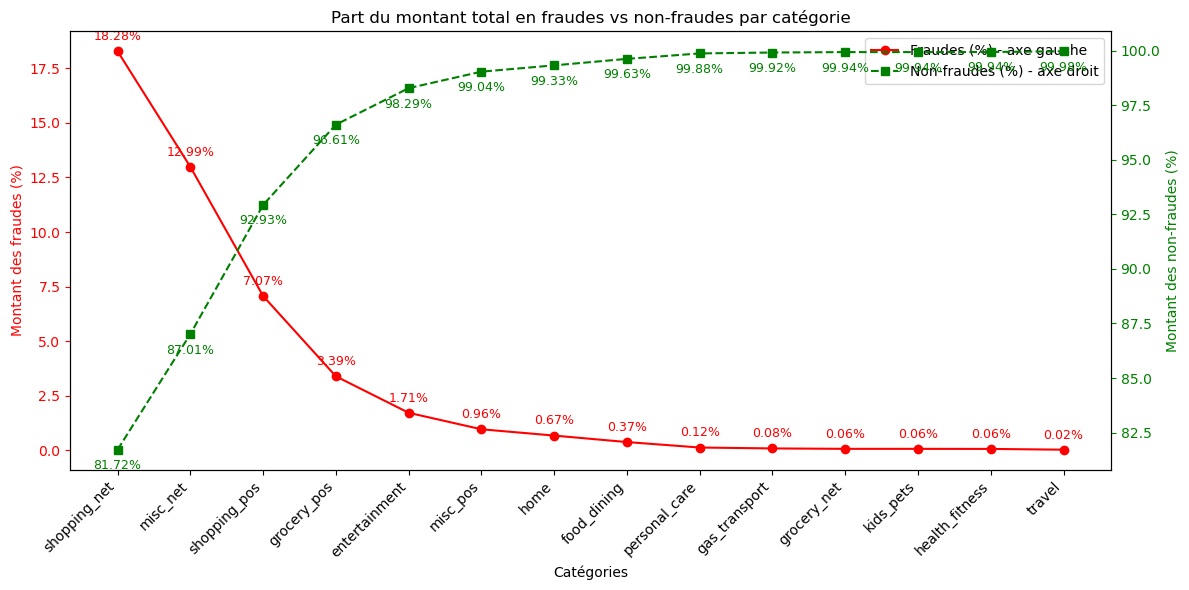

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrégation des montants par catégorie et type (fraude / non-fraude)
montants = (
    data.groupby(['category', 'is_fraud'])['amt']
        .sum()
        .unstack(fill_value=0)
        .reindex(columns=[0, 1], fill_value=0)  # 0 = non-fraude, 1 = fraude
)

# Calcul des pourcentages par catégorie
montants['total'] = montants[0] + montants[1]
montants['fraude_%'] = montants[1] / montants['total'] * 100
montants['non_fraude_%'] = montants[0] / montants['total'] * 100

# Trier par pourcentage de fraudes décroissant
montants = montants.sort_values(by='fraude_%', ascending=False)

# Préparer les données pour le graphique
cats = montants.index.tolist()
x = range(len(cats))
fraude_pct = montants['fraude_%'].values
non_fraude_pct = montants['non_fraude_%'].values

# Création du graphique
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Courbe des fraudes (axe gauche)
l1, = ax1.plot(x, fraude_pct, color='red', marker='o', linestyle='-',
               label='Fraudes (%) - axe gauche')
ax1.set_ylabel('Montant des fraudes (%)', color='red')
ax1.tick_params(axis='y', colors='red')

# Courbe des non-fraudes (axe droit)
l2, = ax2.plot(x, non_fraude_pct, color='green', marker='s', linestyle='--',
               label='Non-fraudes (%) - axe droit')
ax2.set_ylabel('Montant des non-fraudes (%)', color='green')
ax2.tick_params(axis='y', colors='green')

# Titres et étiquettes
ax1.set_title("Part du montant total en fraudes vs non-fraudes par catégorie")
ax1.set_xlabel("Catégories")
ax1.set_xticks(x)
ax1.set_xticklabels(cats, rotation=45, ha='right')

# Annoter les points (valeurs en %)
for i, v in enumerate(fraude_pct):
    ax1.annotate(f"{v:.2f}%", xy=(i, v), xytext=(0, 8),
                 textcoords="offset points", ha='center', color='red', fontsize=9)

for i, v in enumerate(non_fraude_pct):
    ax2.annotate(f"{v:.2f}%", xy=(i, v), xytext=(0, -14),
                 textcoords="offset points", ha='center', color='green', fontsize=9)

# Légende combinée
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


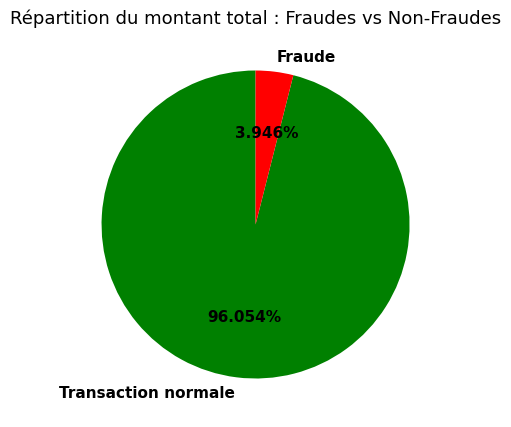

In [163]:
import matplotlib.pyplot as plt

# 1️⃣ Calcul des montants totaux par type
montants = data.groupby('is_fraud')['amt'].sum()

# 2️⃣ Calcul des pourcentages
total = montants.sum()
pourcentages = montants / total * 100

# 3️⃣ Préparation des labels
labels = ['Transaction normale', 'Fraude']
colors = ['green', 'red']

# 4️⃣ Graphique
fig, ax = plt.subplots(figsize=(6, 5))
wedges, texts, autotexts = ax.pie(
    pourcentages,
    labels=labels,
    colors=colors,
    autopct=lambda p: f"{p:.3f}%",
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Titre et affichage
plt.title("Répartition du montant total : Fraudes vs Non-Fraudes", fontsize=13)
plt.show()


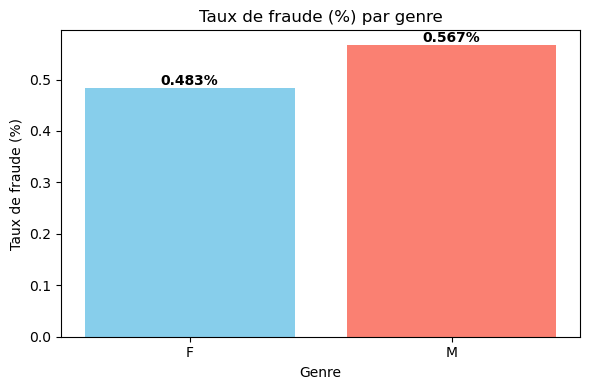

In [171]:
import matplotlib.pyplot as plt

# Calcul des totaux et des fraudes par genre
total_par_genre = data['gender'].value_counts()
fraudes_par_genre = data[data['is_fraud'] == 1]['gender'].value_counts()

# Calcul du taux de fraude (%)
taux_fraude = (fraudes_par_genre / total_par_genre * 100).fillna(0).sort_index()

# Tracé du barplot
plt.figure(figsize=(6,4))
plt.bar(taux_fraude.index, taux_fraude.values, color=['skyblue', 'salmon'])
plt.title("Taux de fraude (%) par genre")
plt.xlabel("Genre")
plt.ylabel("Taux de fraude (%)")

# Ajouter les valeurs sur les barres (en %)
for i, v in enumerate(taux_fraude.values):
    plt.text(i, v + 0.01 * max(taux_fraude.values),
             f"{v:.3f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


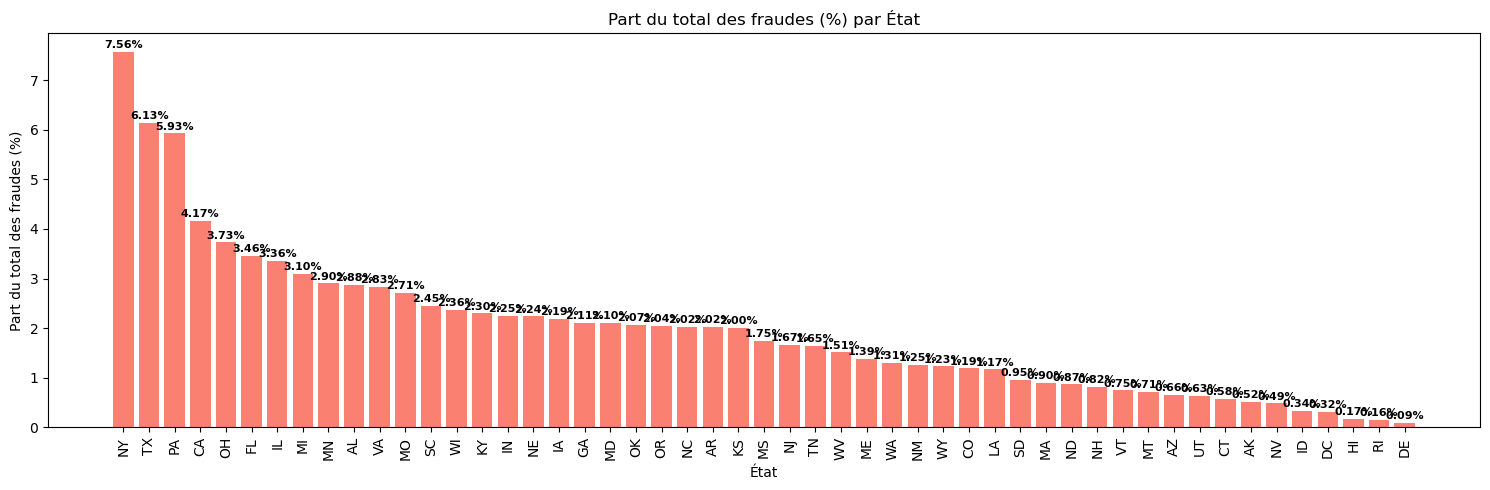

In [203]:
import matplotlib.pyplot as plt

# 1️⃣ Calcul du nombre total de fraudes par état
fraudes_par_state = data[data['is_fraud'] == 1]['state'].value_counts()

# 2️⃣ Calcul du pourcentage de fraude de chaque état par rapport au total des fraudes
taux_fraude_state = (fraudes_par_state / fraudes_par_state.sum() * 100).sort_values(ascending=False)

# 3️⃣ Tracé du barplot
plt.figure(figsize=(15,5))
plt.bar(taux_fraude_state.index, taux_fraude_state.values, color='salmon')
plt.title("Part du total des fraudes (%) par État")
plt.xlabel("État")
plt.ylabel("Part du total des fraudes (%)")

# 4️⃣ Ajouter les valeurs en pourcentage sur les barres
for i, v in enumerate(taux_fraude_state.values):
    plt.text(i, v + 0.01 * max(taux_fraude_state.values),
             f"{v:.2f}%", ha='center', fontweight='bold', fontsize=8)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 3. Modelisation

In [214]:
# Afficher les colonnes non numériques
non_num_cols = data.select_dtypes(exclude=['int64', 'float64']).columns
print("Variables non numériques :", list(non_num_cols))
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_num_cols:
    data[col] = le.fit_transform(data[col].astype(str))


Variables non numériques : ['merchant', 'category', 'gender', 'city', 'state', 'job', 'mois', 'semaine']


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1852393
Data columns (total 16 columns):
 #   Column     Dtype  
---  ------     -----  
 0   cc_num     int64  
 1   merchant   int32  
 2   category   int32  
 3   amt        float64
 4   gender     int32  
 5   city       int32  
 6   state      int32  
 7   zip        int64  
 8   city_pop   int64  
 9   job        int32  
 10  unix_time  int64  
 11  is_fraud   int64  
 12  age        float64
 13  mois       int32  
 14  semaine    int32  
 15  distance   float64
dtypes: float64(3), int32(8), int64(5)
memory usage: 248.2 MB


In [239]:
# === Imports
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === 0) Données -> X / y (ajuste si tu as déjà X_train_scaled, etc.)
X = data.drop(columns=['is_fraud'])
y = data['is_fraud'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 1) Gestion du déséquilibre
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)  # évite division par zéro

# === 2) Modèle XGBoost (rapide et robuste)
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,   # clé pour le déséquilibre
    objective='binary:logistic',
    eval_metric=['aucpr','auc'],         # PR AUC = métrique phare en fraude
    tree_method='hist',                  # très rapide
    random_state=42,
    n_jobs=-1
)

# === 3) Entraînement avec early stopping
xgb.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False)

# === 4) Prédictions + métriques
proba = xgb.predict_proba(X_test_scaled)[:, 1]
y_pred = (proba >= 0.5).astype(int)  # seuil par défaut (ajustable)

print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred, zero_division=0))
print("Recall          :", recall_score(y_test, y_pred))
print("F1-score        :", f1_score(y_test, y_pred))
print("ROC AUC         :", roc_auc_score(y_test, proba))
print("PR AUC (AP)     :", average_precision_score(y_test, proba))  # très pertinent en classe rare
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))

# === 5) (Option) Optimiser le seuil pour maximiser F1 (ou Recall à précision mini)
best_t = 0.5
best_f1 = 0
for t in np.linspace(0.01, 0.7, 70):
    yp = (proba >= t).astype(int)
    f1 = f1_score(y_test, yp)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\nSeuil optimal F1 ≈ {best_t:.2f}  (F1={best_f1:.4f})")
y_pred_opt = (proba >= best_t).astype(int)
print("Recall@t*      :", recall_score(y_test, y_pred_opt))
print("Precision@t*   :", precision_score(y_test, y_pred_opt, zero_division=0))
print("F1@t*          :", f1_score(y_test, y_pred_opt))



KeyboardInterrupt



In [237]:
# === Imports
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === 0) Données -> X / y (ajuste si tu as déjà X_train_scaled, etc.)
X = data.drop(columns=['is_fraud'])
y = data['is_fraud'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 1) Gestion du déséquilibre
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)  # évite division par zéro

# === 2) Modèle XGBoost (rapide et robuste)
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,   # clé pour le déséquilibre
    objective='binary:logistic',
    eval_metric=['aucpr','auc'],         # PR AUC = métrique phare en fraude
    tree_method='hist',                  # très rapide
    random_state=42,
    n_jobs=-1
)

# === 3) Entraînement avec early stopping
xgb.fit(X_train_scaled, y_train, verbose=False)

# === 4) Prédictions + métriques
proba = xgb.predict_proba(X_test_scaled)[:, 1]
y_pred = (proba >= 0.97).astype(int)  # seuil par défaut (ajustable)

print("ROC AUC         :", roc_auc_score(y_test, proba))
print("PR AUC (AP)     :", average_precision_score(y_test, proba))  # très pertinent en classe rare
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))


ROC AUC         : 0.9988084457860702
PR AUC (AP)     : 0.9189314561749502

Matrice de confusion :
 [[368303    246]
 [   363   1567]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9990    0.9993    0.9992    368549
           1     0.8643    0.8119    0.8373      1930

    accuracy                         0.9984    370479
   macro avg     0.9317    0.9056    0.9182    370479
weighted avg     0.9983    0.9984    0.9983    370479



In [241]:
# === Imports
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === 0) Données -> X / y (ajuste si tu as déjà X_train_scaled, etc.)
X = data.drop(columns=['is_fraud'])
y = data['is_fraud'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 1) Gestion du déséquilibre
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)  # évite division par zéro

# === 2) Modèle XGBoost (rapide et robuste)
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,   # clé pour le déséquilibre
    objective='binary:logistic',
    eval_metric=['aucpr','auc'],         # PR AUC = métrique phare en fraude
    tree_method='hist',                  # très rapide
    random_state=42,
    n_jobs=-1
)

# === 3) Entraînement avec early stopping
xgb.fit(X_train_scaled, y_train, verbose=False)

# === 4) Prédictions + métriques
proba = xgb.predict_proba(X_test_scaled)[:, 1]
y_pred = (proba >= 0.5).astype(int)  # seuil par défaut (ajustable)

print("ROC AUC         :", roc_auc_score(y_test, proba))
print("PR AUC (AP)     :", average_precision_score(y_test, proba))  # très pertinent en classe rare
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))


ROC AUC         : 0.9988084457860702
PR AUC (AP)     : 0.9189314561749502

Matrice de confusion :
 [[366028   2521]
 [    63   1867]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9998    0.9932    0.9965    368549
           1     0.4255    0.9674    0.5910      1930

    accuracy                         0.9930    370479
   macro avg     0.7127    0.9803    0.7937    370479
weighted avg     0.9968    0.9930    0.9944    370479



In [243]:
# === Imports
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === 0) Données -> X / y
X = data.drop(columns=['is_fraud'])
y = data['is_fraud'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 1) Gestion du déséquilibre
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

# === 2) Modèle XGBoost
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# === 3) Entraînement (sans early stopping ni eval_set)
xgb.fit(X_train_scaled, y_train, verbose=False)

# === 4) Prédictions + métriques (sans probabilités)
y_pred = xgb.predict(X_test_scaled)


print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))



Matrice de confusion :
 [[366028   2521]
 [    63   1867]]

Rapport de classification :
               precision    recall  f1-score   support

           0     0.9998    0.9932    0.9965    368549
           1     0.4255    0.9674    0.5910      1930

    accuracy                         0.9930    370479
   macro avg     0.7127    0.9803    0.7937    370479
weighted avg     0.9968    0.9930    0.9944    370479

